In [1]:
# Imports
import os
from os.path import join as join_path
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
import pickle
import pandas as pd
from tqdm.auto import tqdm

import tensorflow as tf
tf.random.set_seed(rng_seed)
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.utils import plot_model, to_categorical, Progbar
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json

from models import build_word2vec_model_dense

In [2]:
# Define constants
# ----------------
data_dir = 'data'
checkpoints_dir = 'checkpoints'
text8_data_tokenizer_config_path = join_path(data_dir, 'text8-tokenizer.json')
text8_data_sequences_path = join_path(data_dir, 'text8-seqs.p')
os.makedirs(checkpoints_dir, exist_ok=True)

# We have over 30k articles with a large vocubulary. Due to computational
# restrictions, we limit ourselves to the top 1000 words from all texts.
max_vocab_size = 1000
sampling_window_size = 5
num_negative_samples = 15
embedding_dim = 100

# Training constants
epochs = 15
batch_size = 64
# ----------------

# Load data

In [3]:
# Load text8 data sequences from data preprocessing
with open(text8_data_sequences_path, 'rb') as file:
    text8_seqs = pickle.load(file)

In [4]:
# Read tokenizer from file
with open(text8_data_tokenizer_config_path, 'r') as file:
    tokenizer = tokenizer_from_json(file.read())
vocab_size = np.minimum(max_vocab_size, len(tokenizer.word_index))

## Create Word2vec model

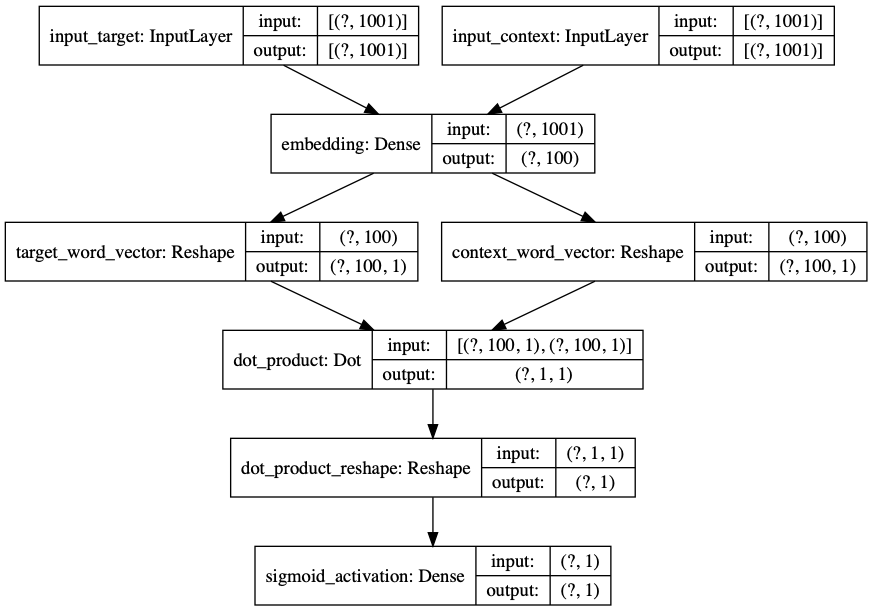

In [5]:
# Create word2vec model
model = build_word2vec_model_dense(vocab_size, embedding_dim)
plot_model(model, show_shapes=True, to_file='word2vec_model.png')

## Fit Word2vec model

In [6]:
# TODO: Compare to https://markroxor.github.io/gensim/static/notebooks/Word2Vec_FastText_Comparison.html
# TODO: Explore Gensim? https://radimrehurek.com/gensim/auto_examples/index.html
def fit_model(model: Model,
              tokenizer: Tokenizer,
              text_seqs: list,
              epochs: int,
              batch_size: int,
              vocab_size: int,
              sampling_window_size: int,
              num_negative_samples: int,
              checkpoints_dir: str = None):
    '''
    TODO: Docs
    '''
    sampling_table = make_sampling_table(vocab_size + 1)
    train_losses = list()
    for epoch in range(1, epochs + 1):
        print(f'-- Epoch #{epoch} --')

        progbar = Progbar(len(text_seqs))
        progbar.update(0)
        
        # Training
        for i, train_text_seq in enumerate(text_seqs):
            
            # Create skipgram pairs
            data_pairs, data_labels = skipgrams(
                train_text_seq,
                vocab_size,
                sampling_table=sampling_table,
                window_size=sampling_window_size,
                negative_samples=num_negative_samples
            )
            data_pairs = np.array(data_pairs)
            data_labels = np.array(data_labels).reshape(-1, 1)
            # TODO: Sample from data_pairs/data_labels

            num_skipgram_pairs = len(data_pairs)
            indices = np.arange(num_skipgram_pairs, dtype=int)
            np.random.shuffle(indices)

            # Train model in batches of skipgram pairs
            num_batches = int(np.ceil(num_skipgram_pairs / batch_size))
            for batch_nr in range(num_batches):
                indices_batch = indices[batch_nr * batch_size:(batch_nr + 1) * batch_size]

                batch_pairs = list(to_categorical(data_pairs[indices_batch].T, num_classes=vocab_size + 1))
                batch_labels = data_labels[indices_batch]

                train_loss = model.train_on_batch(batch_pairs, batch_labels)
                progbar.update(i + 1, values=[('train_loss', sum(train_loss))])

        # Save model to file
        if not checkpoints_dir is None:
            # TODO: Save train_loss to file after each epoch
            
            model_checkpoint_path = join_path(checkpoints_dir, f'word2vec-model-epoch-{epoch}.model')
            print(f'Saving model to {model_checkpoint_path}...')
            model.save(model_checkpoint_path)
            print('Done!')

In [7]:
train_model = True
if train_model:
    fit_model(
        model,
        tokenizer,
        text8_seqs,
        epochs,
        batch_size,
        vocab_size,
        sampling_window_size,
        num_negative_samples,
        checkpoints_dir=checkpoints_dir
    )

-- Epoch #1 --
  3179/504749 [..............................] - ETA: 37:46 - train_loss: 1.2702

KeyboardInterrupt: 